<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Save files</a></span></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Old-characterizations" data-toc-modified-id="Old-characterizations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Old characterizations</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from os import path
import sys
sys.path.append('/home/annie/Documents/multi-Ecoli/strains/')
from pymodulon.core import IcaData
from pymodulon.plotting import *
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = path.join('..','data','processed_data')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join('..','data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [6]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata.tsv'),index_col=0,sep='\t')
df_metadata[['project','condition']].head()

,project,condition
Experiment,,
SRX10864008,photomixotrophic,photoautotroph
SRX10864009,photomixotrophic,photoautotroph
SRX10864010,photomixotrophic,photoautotroph
SRX10864011,photomixotrophic,glucose
SRX10864012,photomixotrophic,glucose


In [7]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [8]:
df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
df_trn.head()

,regulator,gene_id,effect
0,arsR,Synpcc7942_0688,-
1,ccmR,Synpcc7942_1488,-
2,ccmR,Synpcc7942_1489,-
3,ccmR,Synpcc7942_1490,-
4,ccmR,Synpcc7942_1491,-


The `regulator` and `gene_id` must be filled in for each row

In [9]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [42]:
ica_data = IcaData(M = path.join('../data/processed_data/dimensions/130_optimal/','S.csv'),
                   A = path.join('../data/processed_data/dimensions/130_optimal/','A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join('../data/processed_data/','gene_info.csv'),
                   sample_table = path.join(data_dir,'metadata.tsv'),
                   trn = path.join(external_data,'TRN.csv'),
                   optimize_cutoff=True)

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [43]:
# ica_data = IcaData(M = path.join(data_dir,'M.csv'),
#                    A = path.join(data_dir,'A.csv'),
#                    X = path.join(data_dir,'log_tpm_norm.csv'),
#                    gene_table = path.join(data_dir,'gene_info.csv'),
#                    sample_table = path.join(data_dir,'metadata.tsv'),
#                    trn = path.join(data_dir,'TRN.csv'),
#                    threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [44]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,13,ccmR,1.397716e-10,1.397716e-10,0.227273,0.833333,0.357143,5.0,6.0,22.0,1.0
1,21,ntcA,1.258998e-25,2.517997e-25,0.750000,0.666667,0.705882,12.0,18.0,16.0,1.0
2,21,ntcB,3.325249e-12,3.325249e-12,0.375000,0.600000,0.461538,6.0,10.0,16.0,1.0
3,40,ntcA,2.770449e-09,8.311348e-09,0.175000,0.388889,0.241379,7.0,18.0,40.0,1.0
4,47,ccmR,4.965229e-10,9.930457e-10,0.500000,0.666667,0.571429,4.0,6.0,8.0,1.0
5,54,sufR,2.985369e-13,2.985369e-13,0.625000,0.833333,0.714286,5.0,6.0,8.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [45]:
# First search for regulator enrichments with 2 regulators
ica_data.compute_trn_enrichment(max_regs=2,save=True)

# Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
ica_data.compute_trn_enrichment(max_regs=1,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,13,ccmR,1.397716e-10,1.397716e-10,0.227273,0.833333,0.357143,5.0,6.0,22.0,1.0
1,21,ntcA,1.258998e-25,2.517997e-25,0.750000,0.666667,0.705882,12.0,18.0,16.0,1.0
2,21,ntcB,3.325249e-12,3.325249e-12,0.375000,0.600000,0.461538,6.0,10.0,16.0,1.0
3,40,ntcA,2.770449e-09,8.311348e-09,0.175000,0.388889,0.241379,7.0,18.0,40.0,1.0
4,47,ccmR,4.965229e-10,9.930457e-10,0.500000,0.666667,0.571429,4.0,6.0,8.0,1.0
5,54,sufR,2.985369e-13,2.985369e-13,0.625000,0.833333,0.714286,5.0,6.0,8.0,1.0


The list of regulatory iModulons are shown below

In [46]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
print(len(ica_data.imodulon_table),'Total iModulons')
print(len(regulatory_imodulons),'Regulatory iModulons')
regulatory_imodulons

57 Total iModulons
5 Regulatory iModulons


,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
13,ccmR,1.397716e-10,1.397716e-10,0.227273,0.833333,0.357143,5.0,6.0,22.0,1.0
21,ntcA,1.258998e-25,2.517997e-25,0.750000,0.666667,0.705882,12.0,18.0,16.0,1.0
40,ntcA,2.770449e-09,8.311348e-09,0.175000,0.388889,0.241379,7.0,18.0,40.0,1.0
47,ccmR,4.965229e-10,9.930457e-10,0.500000,0.666667,0.571429,4.0,6.0,8.0,1.0
54,sufR,2.985369e-13,2.985369e-13,0.625000,0.833333,0.714286,5.0,6.0,8.0,1.0


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [47]:
ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [19]:
DF_GO = pd.read_csv(path.join(external_data,'GO_annotations_curated.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_name,gene_ontology
0,Synpcc7942_1426,cbbL,carboxysome
1,Synpcc7942_1534,ago,DNA endonuclease activity
2,Synpcc7942_1535,rbcX,cytoplasm|carboxysome
3,Synpcc7942_1891,labA,circadian rhythm
4,Synpcc7942_2462,PSK,ATP binding|D-ribulokinase activity


In [20]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [21]:
DF_GO_enrich.head()

,imodulon,gene_ontology,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,ccm-1,carboxysome,2.958085e-15,1.271976e-13,0.538462,0.636364,0.583333,7.0,13.0,13.0
1,ccm-1,carboxysome|structural constituent of carboxys...,2.346911e-08,3.363906e-07,0.307692,0.500000,0.380952,4.0,8.0,13.0
2,ccm-1,structural constituent of carboxysome,2.346911e-08,3.363906e-07,0.307692,0.500000,0.380952,4.0,10.0,13.0
3,ccm-1,carbonate dehydratase activity,2.190737e-05,2.355042e-04,0.153846,1.000000,0.266667,2.0,2.0,13.0
4,ccm-1,carboxysome|carbonate dehydratase activity,4.870738e-03,4.188835e-02,0.076923,1.000000,0.142857,1.0,1.0,13.0


## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [22]:
DF_KEGG = pd.read_csv(path.join(external_data,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
6,Synpcc7942_0001,KEGG_pathway,map00230
7,Synpcc7942_0001,KEGG_pathway,map00240
8,Synpcc7942_0001,KEGG_pathway,map01100
9,Synpcc7942_0001,KEGG_pathway,map03030
10,Synpcc7942_0001,KEGG_pathway,map03430


In [23]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [24]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [25]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,PSII,map00195,5.830475e-05,1.195247e-02,0.238095,0.087719,0.128205,5.0,57.0,21.0
1,ribosome-1,map03010,6.970523e-39,1.428957e-36,0.884615,0.433962,0.582278,23.0,53.0,26.0
2,UV,map00196,2.293707e-16,4.702100e-14,0.155844,0.750000,0.258065,12.0,16.0,77.0
3,UV,map00195,1.672395e-11,1.714204e-09,0.194805,0.263158,0.223881,15.0,57.0,77.0
4,UV,map01100,3.859217e-08,2.637131e-06,0.480519,0.067518,0.118400,37.0,548.0,77.0


In [26]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,ccm-1,M00166,4.537653e-04,7.890851e-02,0.153846,0.285714,0.200000,2.0,7.0,13.0
1,ccm-1,M00532,7.736129e-04,7.890851e-02,0.153846,0.222222,0.181818,2.0,9.0,13.0
2,ccm-1,M00165,1.406629e-03,9.565078e-02,0.153846,0.166667,0.160000,2.0,12.0,13.0
3,ribosome-1,M00178,6.970523e-39,1.421987e-36,0.884615,0.433962,0.582278,23.0,53.0,26.0
4,ribosome-1,M00179,3.596169e-35,3.668093e-33,0.730769,0.633333,0.678571,19.0,30.0,26.0


### Convert KEGG IDs to human-readable names

In [27]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [28]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,PSII,map00195,5.830475e-05,1.195247e-02,0.238095,0.087719,0.128205,5.0,57.0,21.0,Photosynthesis
1,ribosome-1,map03010,6.970523e-39,1.428957e-36,0.884615,0.433962,0.582278,23.0,53.0,26.0,Ribosome
2,UV,map00196,2.293707e-16,4.702100e-14,0.155844,0.750000,0.258065,12.0,16.0,77.0,Photosynthesis - antenna proteins
3,UV,map00195,1.672395e-11,1.714204e-09,0.194805,0.263158,0.223881,15.0,57.0,77.0,Photosynthesis
4,UV,map01100,3.859217e-08,2.637131e-06,0.480519,0.067518,0.118400,37.0,548.0,77.0,Metabolic pathways


In [29]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,ccm-1,M00166,4.537653e-04,7.890851e-02,0.153846,0.285714,0.200000,2.0,7.0,13.0,NaN
1,ccm-1,M00532,7.736129e-04,7.890851e-02,0.153846,0.222222,0.181818,2.0,9.0,13.0,Photorespiration
2,ccm-1,M00165,1.406629e-03,9.565078e-02,0.153846,0.166667,0.160000,2.0,12.0,13.0,Reductive pentose phosphate cycle (Calvin cycle)
3,ribosome-1,M00178,6.970523e-39,1.421987e-36,0.884615,0.433962,0.582278,23.0,53.0,26.0,None
4,ribosome-1,M00179,3.596169e-35,3.668093e-33,0.730769,0.633333,0.678571,19.0,30.0,26.0,None


## Save files

In [30]:
DF_GO_enrich['source'] = 'GO'
DF_pathway_enrich['source'] = 'KEGG pathways'
DF_module_enrich['source'] = 'KEGG modules'

DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)

DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich])
DF_enrichments.to_csv(path.join(data_dir,'functional_enrichments.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [61]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

14

In [62]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [63]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene
SG_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [64]:
ica_data.view_imodulon('SG_1')

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
Synpcc7942_0601,0.095330,Synpcc7942_0601,CP000100.1,NaN,590130,590390,-,hypothetical protein,No COG annotation,Q31QN6,Op469,NaN
Synpcc7942_0726,0.074952,Synpcc7942_0726,CP000100.1,NaN,720068,720430,+,conserved hypothetical protein,No COG annotation,Q31QB1,Op565,NaN
Synpcc7942_0845,0.643671,Synpcc7942_0845,CP000100.1,NaN,839873,840079,+,conserved hypothetical protein,No COG annotation,Q31PZ3,Op648,NaN
Synpcc7942_1041,0.079109,Synpcc7942_1041,CP000100.1,NaN,1055349,1055621,-,hypothetical protein,No COG annotation,Q31PE8,Op795,NaN
Synpcc7942_2065,0.090690,Synpcc7942_2065,CP000100.1,NaN,2141928,2142182,-,conserved hypothetical protein,No COG annotation,Q31LH4,Op1555,NaN
Synpcc7942_2233,0.086502,Synpcc7942_2233,CP000100.1,NaN,2299796,2300113,-,hypothetical protein,No COG annotation,Q31L06,Op1674,NaN


# Old characterizations

In [35]:
from pymodulon.io import *
from pymodulon.compare import *

In [36]:
old = load_json_model('../Tahani/selon.json')

In [37]:
mapping = pd.read_csv('../data/external/1_gene_mapping_biocyc.csv')
mapping = mapping.rename(columns={'objecct_id':'gene','new_locus':'subject'})
mapping['gene'] = mapping['gene'].str.replace('SYNPCC7942', 'Synpcc7942')
mapping.head()

,gene,subject,name
0,Synpcc7942_R0020,SYNPCC7942_RS12910,tRNA-Asp1
1,Synpcc7942_R0033,SYNPCC7942_RS02990,tRNA-Ile1
2,Synpcc7942_R0016,SYNPCC7942_RS12495,tRNA-Ser2
3,Synpcc7942_R0048,SYNPCC7942_RS07055,tRNA-Leu3
4,Synpcc7942_R0030,SYNPCC7942_RS01480,tRNA-Ala3


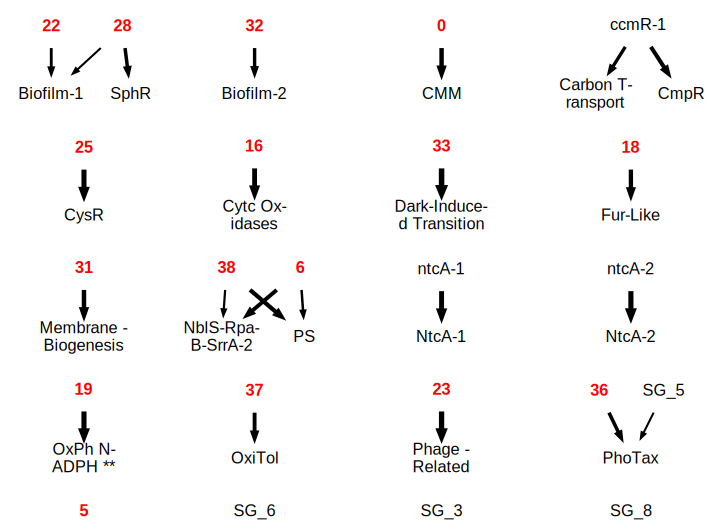

In [65]:
dots,links = compare_ica(ica_data.M,old.M,cutoff=0.3,
                         ortho_file = mapping)
links

In [67]:
hits_dict = dict((x[0], x[1]) for x in dots)
hits = [x[0]for x in dots]
for i in ica_data.imodulon_names:
    if 'SG_' not in str(i) and i in hits and hits.count(i) == 1:
        hit_imod = hits_dict[i]
        if 'SG' not in hit_imod and 'U_' not in hit_imod:
            ica_data.rename_imodulons({i:hit_imod})

# Save iModulon object

In [68]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [69]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [70]:
data_dir

'../data/processed_data'

In [71]:
save_to_json(ica_data, path.join(data_dir,'ica_wip.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [72]:
ica_data.imodulon_table.to_csv(path.join(data_dir,'imodulon_table_raw.csv'))